In [121]:
import re
import unicodedata
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import env
from sklearn.model_selection import train_test_split
import acquire as a
import prepare as p

# 1. Load the spam data set.

In [5]:
query = 'SELECT * FROM spam'
connection = env.get_db_url('spam_db')
spam = pd.read_sql(query, connection, index_col='id')

In [6]:
spam.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
def train_split(df):
    train_validate, test = train_test_split(df,
                                            random_state=1349,
                                            train_size=0.8,
                                           stratify=df.label)
    train, validate = train_test_split(train_validate,
                                       random_state=1349,
                                       train_size=0.7,
                                      stratify=train_validate.label)
    return train, validate, test

In [20]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [18]:
train, validate, test = train_split(spam)
spam.shape, train.shape, validate.shape, test.shape

((5572, 2), (3119, 2), (1338, 2), (1115, 2))

In [73]:
ham_df = clean(' '.join(train[train.label == 'ham']['text']))
spam_df = clean(' '.join(train[train.label == 'spam']['text']))
all_df = clean(' '.join(train['text']))

# 2. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [58]:
# create bigrams
ham_bigrams = nltk.ngrams(ham_df, 2)
spam_bigrams = nltk.ngrams(spam_df, 2)
all_bigrams = nltk.ngrams(all_df, 2)

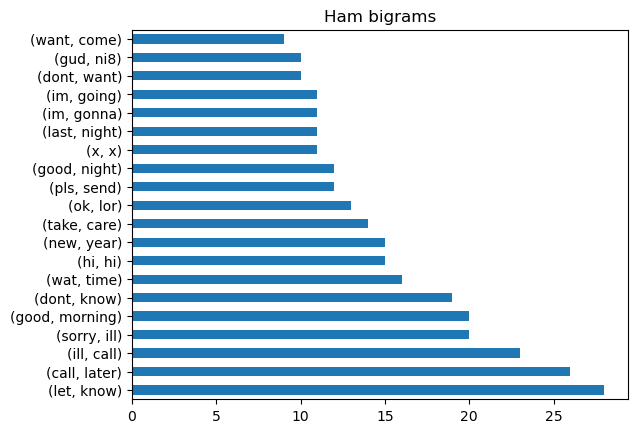

In [59]:
pd.Series(ham_bigrams).value_counts().head(20).plot.barh(title='Ham bigrams');

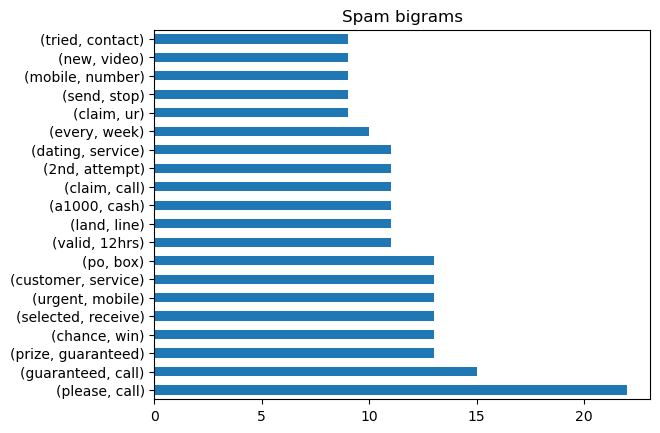

In [60]:
pd.Series(spam_bigrams).value_counts().head(20).plot.barh(title='Spam bigrams');

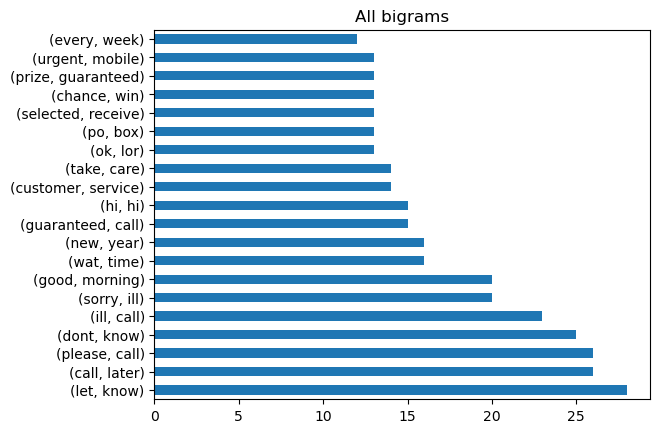

In [61]:
pd.Series(all_bigrams).value_counts().head(20).plot.barh(title='All bigrams');

In [62]:
ham_grams = [thing[0] + '_' + thing[1] for thing in list(nltk.bigrams(ham_df))]
spam_grams = [thing[0] + '_' + thing[1] for thing in list(nltk.bigrams(spam_df))]
all_grams = [thing[0] + '_' + thing[1] for thing in list(nltk.bigrams(all_df))]

In [69]:
type(ham_grams[:5])

list

In [65]:
spam_grams[:5]

['2p_per', 'per_min', 'min_call', 'call_germany', 'germany_08448350055']

In [72]:
all_grams[:5]

['er_hello', 'hello_thing', 'thing_didnut', 'didnut_quite', 'quite_go']

In [75]:
' '.join(all_grams[:4])

'er_hello hello_thing thing_didnut didnut_quite'

In [85]:
all_cloud = WordCloud(background_color='white',
                      height=1000, width=400).generate(' '.join(all_grams))
ham_cloud = WordCloud(background_color='white',
                      height=600, width=1000).generate(' '.join(ham_grams))
spam_cloud = WordCloud(background_color='white',
                       height=600, width=1000).generate(' '.join(spam_grams))

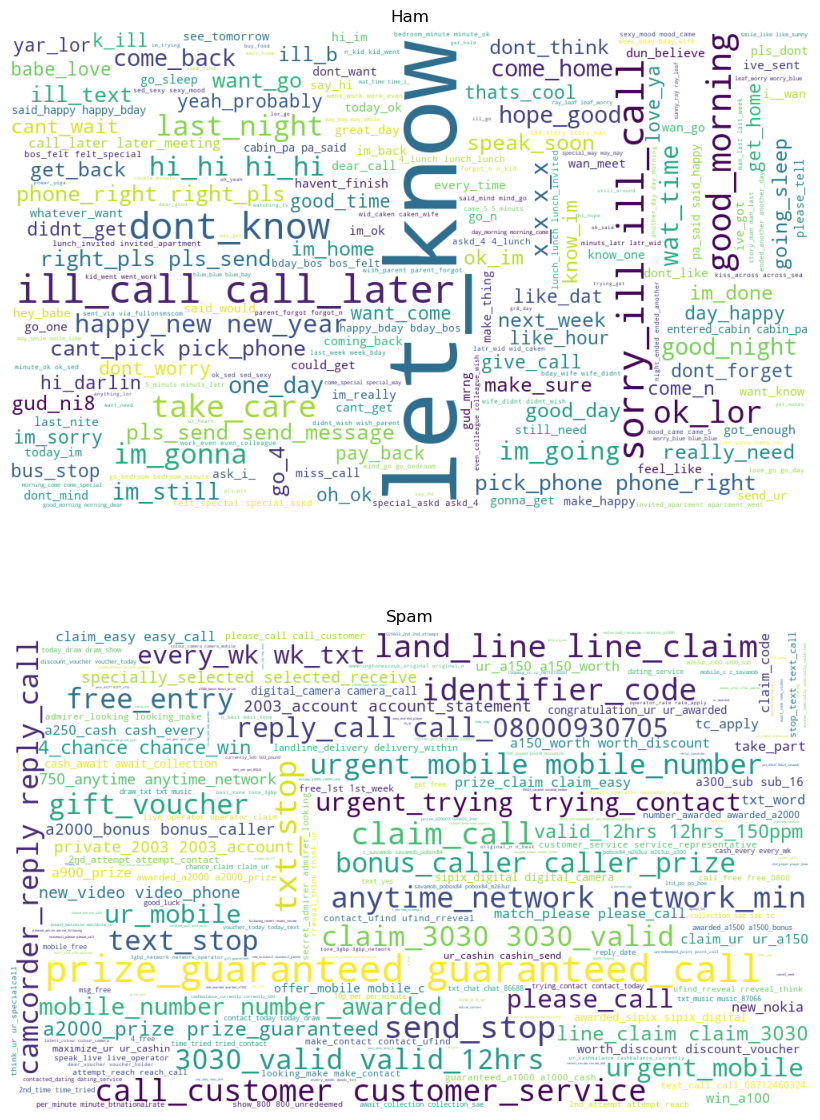

In [91]:

plt.figure(figsize=(16, 12))
axs = [plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(ham_cloud)
axs[1].imshow(spam_cloud)

axs[0].set_title('Ham')
axs[1].set_title('Spam')

for ax in axs: ax.axis('off')


### How do the spam bigrams compare with the ham bigrams?

The ham bigrams have a lot more first person language (im, ill), there are more greetings and salutations, along with much more familair language. The spam bigrams mention prizes and claiming far more, along with urgency and requests for contact.

## 3. Is there any overlap in the bigrams for the spam data and the ham data?

In [97]:
pd.Series(all_grams)

0             er_hello
1          hello_thing
2         thing_didnut
3         didnut_quite
4             quite_go
             ...      
28490       themob_wap
28491     wap_bookmark
28492    bookmark_text
28493         text_wap
28494        wap_82468
Length: 28495, dtype: object

In [98]:
bigram_counts = (pd.concat([pd.Series(all_grams).value_counts(),
                            pd.Series(ham_grams).value_counts(),
                            pd.Series(spam_grams).value_counts()
                            ], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

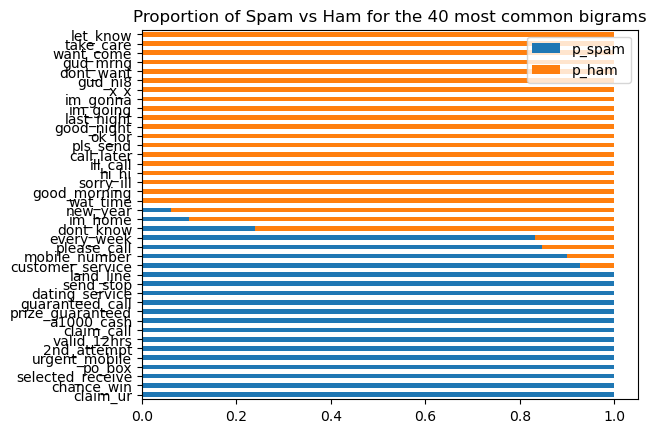

In [111]:
# figure out the percentage of spam vs ham
(bigram_counts
 .assign(p_spam=bigram_counts.spam / bigram_counts['all'],
         p_ham=bigram_counts.ham / bigram_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(40)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 40 most common bigrams');

In [106]:
bigram_counts

,all,ham,spam
0089my_last,1,0,1
01223585236_xx,1,0,1
0125698789_ring,1,1,0
020603_2nd,4,0,4
02070836089_kit,0,0,1
...,...,...,...
zebra_animation,1,0,1
zed_08701417012150p,1,0,1
zero_saving,1,1,0
zhong_se,1,1,0


### There is very little overlap in bigrams between ham and spam

# 4. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [113]:
ham_3grams = [thing[0] + '_' + thing[1] + '_' + thing[2]
              for thing in list(nltk.ngrams(ham_df, 3))]
spam_3grams = [thing[0] + '_' + thing[1] + '_' + thing[2]
               for thing in list(nltk.ngrams(spam_df, 3))]
all_3grams = [thing[0] + '_' + thing[1] + '_' + thing[2]
              for thing in list(nltk.ngrams(all_df, 3))]

In [114]:
all_3grams[:5]

['er_hello_thing',
 'hello_thing_didnut',
 'thing_didnut_quite',
 'didnut_quite_go',
 'quite_go_plan']

In [117]:
all_cloud = WordCloud(background_color='white',
                      height=1000, width=400).generate(' '.join(all_3grams))
ham_cloud = WordCloud(background_color='white',
                      height=600, width=1000).generate(' '.join(ham_3grams))
spam_cloud = WordCloud(background_color='white',
                       height=600, width=1000).generate(' '.join(spam_3grams))

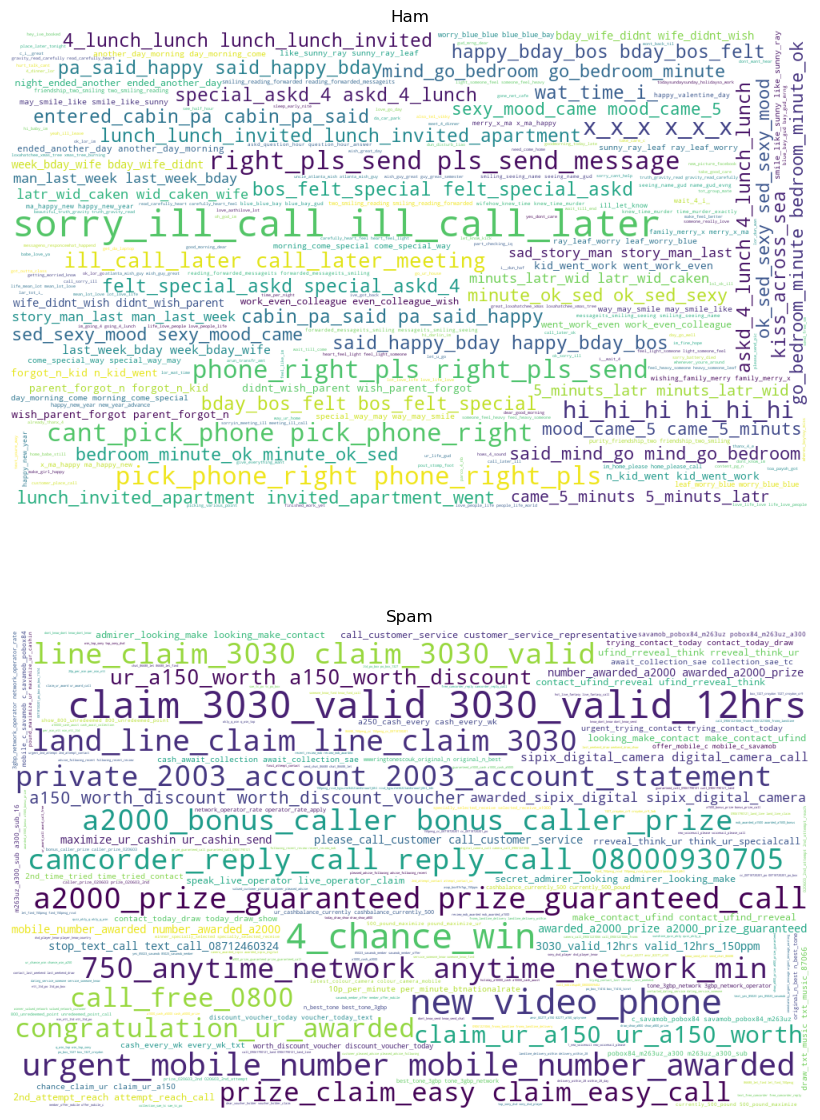

In [118]:
plt.figure(figsize=(16, 12))
axs = [plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(ham_cloud)
axs[1].imshow(spam_cloud)

axs[0].set_title('Ham')
axs[1].set_title('Spam')

for ax in axs: ax.axis('off')

In [119]:
trigram_counts = (pd.concat([pd.Series(all_3grams).value_counts(),
                            pd.Series(ham_3grams).value_counts(),
                            pd.Series(spam_3grams).value_counts()
                            ], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

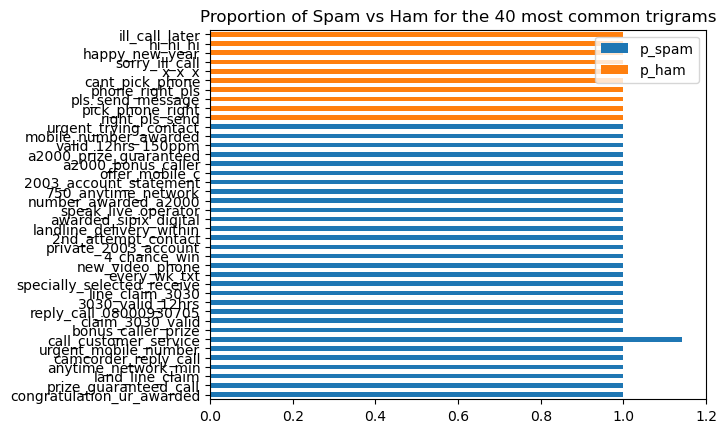

In [120]:
# figure out the percentage of spam vs ham
(trigram_counts
 .assign(p_spam=trigram_counts.spam / trigram_counts['all'],
         p_ham=trigram_counts.ham / trigram_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(40)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 40 most common trigrams');

# Part 2

## Explore the blog articles using the techniques discussed in the exploration lesson.

In [122]:
blogs = a.get_blog_articles()

Opening file codeup_blogs.csv from local directory


In [123]:
blogs = p.prepare_articles(blogs)

In [124]:
blogs.head()

,title,original,clean,stemmed,lemmatized,url
0,Women in tech: Panelist Spotlight – Magdalena ...,\nCodeup is hosting a Women in Tech Panel in h...,codeup hosting women tech panel honor womens h...,codeup host women tech panel honor women histo...,codeup hosting woman tech panel honor woman hi...,https://codeup.com/featured/women-in-tech-pane...
1,Women in tech: Panelist Spotlight – Rachel Rob...,\nCodeup is hosting a Women in Tech Panel in h...,codeup hosting women tech panel honor womens h...,codeup host women tech panel honor women histo...,codeup hosting woman tech panel honor woman hi...,https://codeup.com/featured/women-in-tech-rach...
2,Women in Tech: Panelist Spotlight – Sarah Mellor,\nCodeup is hosting a Women in Tech Panel in ...,codeup hosting women tech panel honor womens h...,codeup host women tech panel honor women histo...,codeup hosting woman tech panel honor woman hi...,https://codeup.com/codeup-news/women-in-tech-p...
3,Women in Tech: Panelist Spotlight – Madeleine ...,\nCodeup is hosting a Women in Tech Panel in h...,codeup hosting women tech panel honor womens h...,codeup host women tech panel honor women histo...,codeup hosting woman tech panel honor woman hi...,https://codeup.com/events/women-in-tech-madele...
4,Black Excellence in Tech: Panelist Spotlight –...,\n\nCodeup is hosting a Black Excellence in Te...,codeup hosting black excellence tech panel hon...,codeup host black excel tech panel honor black...,codeup hosting black excellence tech panel hon...,https://codeup.com/codeup-news/panelist-spotli...


In [126]:
def article_train_split(df):
    train_validate, test = train_test_split(df,
                                            random_state=1349,
                                            train_size=0.8)
    train, validate = train_test_split(train_validate,
                                       random_state=1349,
                                       train_size=0.7)
    return train, validate, test

In [128]:
train_blogs, val_blogs, test_blogs = article_train_split(blogs)

In [129]:
blogs.shape, train_blogs.shape, val_blogs.shape, test_blogs.shape

((158, 6), (88, 6), (38, 6), (32, 6))